```
conda init
conda create -n get-face-embeddings python=3.10 -c conda -y
conda activate get-face-embeddings
pip install torch==2.2.1+cu118 torchvision==0.17.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
pip install facenet-pytorch==2.6.0
pip install pandas
pip install ipykernel
```

In [1]:
import os
import csv
from pathlib import Path
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
import pandas as pd
from IPython.display import display

c:\Users\ExoHorizon\miniconda3\envs\get-face-embeddings\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT = Path("../VoxCeleb2/vox2_test/jpg")
CSV_PATH = Path("../VoxCeleb2/jpg_metadata.csv")
EMB_PATH = Path("../VoxCeleb2/jpg_embeddings.pt")
SAVE_CHUNK = 256

In [3]:
# Device Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [4]:
# MTCNN | Face Detection & Alignment | Not Used For Now
mtcnn = MTCNN(
    image_size=160, 
    margin=0, 
    min_face_size=20, 
    device=device
    )

# Backup | Face Detection & Alignment | Currently Used (Assumes Dataset is Aligned)
fallback_preprocess = T.Compose([
    T.Resize((160, 160)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# FaceNet | Face Embedding Model
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
for param in facenet.parameters():
    param.requires_grad = False

In [5]:
def load_and_preprocess_image(image_path):
    return fallback_preprocess(Image.open(image_path).convert("RGB"))

In [6]:
def load_resume_state():
    """Reads last CSV index to resume correctly."""
    if not CSV_PATH.exists():
        return 0

    with open(CSV_PATH, "r", newline="") as f:
        reader = csv.reader(f)
        rows = list(reader)

        if len(rows) <= 1:
            return 0

        last_index = int(rows[-1][0])
        print(f"[Resume] Last completed index: {last_index}")
        return last_index + 1

In [7]:
# Ensure CSV exists with header
if not CSV_PATH.exists():
    with open(CSV_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["index", "id", "hash", "img_num", "filepath"])

start_index = load_resume_state()

In [8]:
# Scan filesystem
jpg_files = sorted(ROOT.rglob("*.jpg"))
total = len(jpg_files)
print(f"Found {total} jpg files.")

Found 36237 jpg files.


In [9]:
# Load existing embeddings in case resuming
if EMB_PATH.exists():
    all_embeddings = torch.load(EMB_PATH)
    print(f"[Resume] Loaded existing embedding tensor: {all_embeddings.shape}")
else:
    all_embeddings = torch.zeros((0, 512), dtype=torch.float32)

In [10]:
cache_embeddings = []
next_index = start_index

for file_path in tqdm(jpg_files[start_index:], desc="Processing JPGs"):
    # Parse path: id/hash/img_num.jpg
    parts = file_path.parts
    # [..., "jpg", "idxxxxx", "hash", "xxxxx.jpg"]
    id_name = parts[-3]
    hash_name = parts[-2]
    img_num = int(Path(parts[-1]).stem)

    # Load + embed
    face = load_and_preprocess_image(file_path)
    face = face.unsqueeze(0).to(device)

    with torch.no_grad():
        emb = facenet(face)
        emb = torch.nn.functional.normalize(emb, dim=1)
    emb = emb.cpu()

    cache_embeddings.append(emb)

    # Append row to CSV
    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([next_index, id_name, hash_name, img_num, str(file_path)])

    next_index += 1

    # Periodically save embeddings
    if len(cache_embeddings) >= SAVE_CHUNK:
        cache_embeddings = torch.cat(cache_embeddings, dim=0)
        all_embeddings = torch.cat([all_embeddings, cache_embeddings], dim=0)
        torch.save(all_embeddings, EMB_PATH)
        cache_embeddings = []

Processing JPGs: 100%|██████████| 36237/36237 [08:15<00:00, 73.17it/s]


In [11]:
# Save remaining embeddings
if len(cache_embeddings) > 0:
    cache_embeddings = torch.cat(cache_embeddings, dim=0)
    all_embeddings = torch.cat([all_embeddings, cache_embeddings], dim=0)
    torch.save(all_embeddings, EMB_PATH)

In [12]:
# Check CSV File
df = pd.read_csv(CSV_PATH)
print(len(df))
df.head()

36237


,index,id,hash,img_num,filepath
0,0,id00017,01dfn2spqyE,1,..\VoxCeleb2\vox2_test\jpg\id00017\01dfn2spqyE...
1,1,id00017,5MkXgwdrmJw,2,..\VoxCeleb2\vox2_test\jpg\id00017\5MkXgwdrmJw...
2,2,id00017,7t6lfzvVaTM,3,..\VoxCeleb2\vox2_test\jpg\id00017\7t6lfzvVaTM...
3,3,id00017,7t6lfzvVaTM,4,..\VoxCeleb2\vox2_test\jpg\id00017\7t6lfzvVaTM...
4,4,id00017,7t6lfzvVaTM,5,..\VoxCeleb2\vox2_test\jpg\id00017\7t6lfzvVaTM...


In [13]:
# Check Embeddings File
embeddings = torch.load(EMB_PATH)
print(embeddings.shape)
print("Has zeros:", (embeddings.abs().sum(dim=1) == 0).any())
print(embeddings[0][:6])

torch.Size([36237, 512])
Has zeros: tensor(False)
tensor([-0.0032, -0.0250, -0.0102, -0.0041,  0.0246, -0.0271])


In [14]:
# Check Embeddings
index = 67

row = df.iloc[index]
print(row)

vec = embeddings[index]

print("Norm:", torch.norm(vec).item())
print("Min value:", vec.min().item())
print("Max value:", vec.max().item())
print("Embedding vector:", vec[:6])

index                                                      67
id                                                    id00017
hash                                              kN2iEvnTHc4
img_num                                                   135
filepath    ..\VoxCeleb2\vox2_test\jpg\id00017\kN2iEvnTHc4...
Name: 67, dtype: object
Norm: 1.0
Min value: -0.15106205642223358
Max value: 0.13163867592811584
Embedding vector: tensor([0.0256, 0.0088, 0.0075, 0.0110, 0.0403, 0.0125])


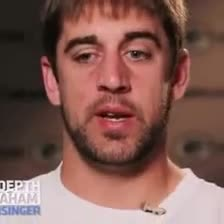

In [15]:
# Display the image
img = Image.open(row["filepath"])
display(img)